# 📘 Building Agentic Apps: ArangoDB, NVIDIA cuGraph, and NetworkX Hackathon

This high-stakes hackathon challenges participants to develop an AI application integrating Agentic Applications, GraphRAG, and NVIDIA cuGraph to enhance GenAI-powered business solutions.

Why GraphRAG?
Unlike traditional RAG systems that rely solely on vector-based retrieval—leading to hallucinations and fragmented context—GraphRAG leverages graph-based retrieval, preserving contextual relationships and improving the accuracy and interpretability of AI-generated responses.

Challenge
Build an application that integrates GraphRAG and GPU-accelerated graph analytics to solve a real-world problem. Participants can choose from:

Bring Your Own Data (BYOD) – Select an open dataset relevant to their use case.
ArangoDB’s Provided Dataset – A pre-configured dataset optimized for GraphRAG tasks.
To simplify development, ArangoDB will provide a Jupyter Notebook with pre-built placeholders to guide the process.

Libraries to use and install:
nx-arangodb: !pip install nx-arangodb
cuGraph: !pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU
langGraph y LangChain: !pip install --upgrade langchain langchain-community langchain-openai langgraph
networkx


Langchain con ArangoDb
ArangoGraph (Opcional) from langchain.graphs import ArangoGraph
ArangoGraphQAChain: from langchain.chains import ArangoGraphQAChain


# 📘 Use Case, Novelty and Impact

This project leverages OpenStreetMap amenity data to unlock valuable insights into local market dynamics and pinpoint untapped business opportunities. Imagine having a clear view of the competitive landscape, revealing areas ripe for expansion or underserved niches waiting to be discovered.

By constructing a network graph based on amenity proximity and density, we can visualize the intricate tapestry of the local market. This allows us to:


*   Identify hotspots and voids: Pinpoint areas with high or low concentrations of specific services, highlighting market saturation or gaps.
*   Understand customer flow: Gain insights into potential customer movement patterns and preferences.
*  Uncover hidden niches: Discover underserved areas or unique combinations of amenities that create opportunities for specialized businesses.


Beyond business applications, this tool has the potential to address critical challenges in various domains:


*   Identify critical service gaps:
*   Optimize infrastructure planning
*   Detect crime hotspots
*   Identify vulnerable communities
*   Analyze the distribution of green spaces and environmental amenities



Think of it as a "Geo X-ray," revealing the hidden structure and opportunities within any local economy.

# ✅ Step #1: install the required modules

In [ ]:
!python --version
!pip install nx-arangodb -q
!pip install --upgrade langchain langchain-community langchain-openai langgraph -q
!pip install networkx -q
!pip install adbnx-adapter -q
!pip install pandas -q
!pip install wget -q
!pip install beautifulsoup4 -q
#!pip install pypdf -q
!pip install PyPDF2 -q
!pip install faiss-cpu -q
!pip install gradio - q
!pip install osmnx -q
print("Packages Installed!")

Python 3.11.11
ERROR: Invalid requirement: '-': Expected package name at the start of dependency specifier
    -
    ^
Packages Installed!


# ✅ Step #2: Import the required modules

In [ ]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient
from arango.exceptions import ArangoServerError  # Corrected import
import pandas as pd
import numpy as np
import networkx as nx
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

from langchain.vectorstores import FAISS
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from bs4 import BeautifulSoup
import requests
#from pypdf import PdfReader
from langchain.schema import Document


#import wget
from langgraph.graph import StateGraph
from typing import TypedDict
import os
from dotenv import load_dotenv

from google.colab import userdata
from google.colab import drive


# ✅ Load environment Variables (API KEYS HERE)

In [ ]:

drive.mount('/content/drive')
# 📁 Define the path in Google Drive where you will save the RAG indexes
drive_path = '/content/drive/MyDrive/faiss_indices' # ⚠️ Make sure this folder exists in your Google Drive!

# Load API keys from Colab secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ARANGO_API_KEY = userdata.get('ARANGO_API_KEY')
ARANGO_HOST_KEY = userdata.get('ARANGO_HOST_KEY')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ✅ Step #3: Connect To Arango Client Database

In [ ]:
 #Connect to the ArangoDB database
db = ArangoClient(hosts= ARANGO_HOST_KEY).db(username="root", password=ARANGO_API_KEY, verify=True)
print(db)

<StandardDatabase _system>


# ⚪ Step #4 Prepare the dataset for NetworkX

## **Dataset and Code Description**
This script utilizes OSMnx and NetworkX to **analyze urban infrastructure and point-of-interest (POI) data based on OpenStreetMap (OSM) data**. The focus is on extracting and integrating restaurant amenities into a walkable street network graph within a 1 km radius of Puerta del Sol, Madrid, Spain.

Dataset Description
Location: Centered around Puerta del Sol, Madrid, Spain.
Points of Interest (POIs): Extracts all restaurants (amenity: restaurant) within a 500m radius.
Street Network: Constructs a walkable street network using OpenStreetMap data within a 1 km radius.
Graph Representation: The street network is represented as a graph, where:
Nodes represent intersections or points along the streets.
Edges represent walkable paths.
Additional POI nodes (restaurants) are added to the graph for urban analysis.

#### Import from OSMX to ArangoGraph

## Example of Graph Data

✅ Added 567 nodes with Points of Interest.


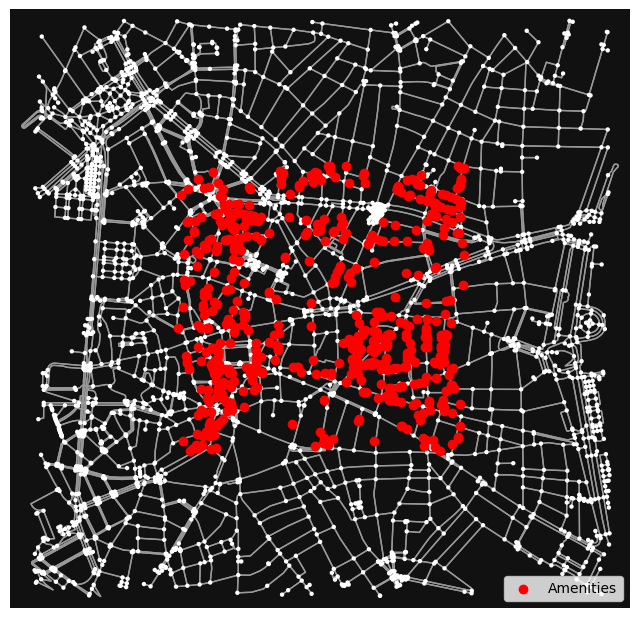

In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
from arango import ArangoClient

# 📌 1.Address Location and Configuration
direccion = "Puerta del Sol, Madrid, España"
punto = ox.geocode(direccion)  # Obtener coordenadas

# 📌 2. Get Bussiness in a 500 metter radius
tags = {"amenity": "restaurant"}
pois = ox.features_from_point(punto, tags, dist=1000)

# Filtrer valid Bussiness
pois = pois.dropna(subset=["amenity"])  # Eliminar NaN en 'amenity'
pois = pois[pois["amenity"].apply(lambda x: isinstance(x, str))]  # Asegurar que sea string
pois = pois[pois.geometry.apply(lambda g: isinstance(g, Point))]  # Filtrar solo puntos

# 📌 3. Construct de Graph
G = ox.graph_from_point(punto, dist=1000, network_type="walk")

# 📌 4. Add Amenities Nodes to the Graph
for idx, row in pois.iterrows():
    G.add_node(idx, x=row.geometry.x, y=row.geometry.y, amenity=row["amenity"])

# 📌 5.
nodos_con_amenity = [n for n, d in G.nodes(data=True) if "amenity" in d]
print(f"✅ Added {len(nodos_con_amenity)} nodes with Points of Interest.")

# 📌 6. Plot the data
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=10)
ax.scatter(pois.geometry.x, pois.geometry.y, c="red", marker="o", label="Amenities")
plt.legend()
plt.show()


## Import Data from Point of Interest with a Defined Radius (0.5 KM)

In [ ]:
import osmnx as ox
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient
from geopy.distance import geodesic
from shapely.geometry import Point

# ----------------- 1️⃣ Obtener Restaurantes desde OpenStreetMap -----------------
direccion = "Madrid, España"
punto = ox.geocode(direccion)

# Filtrar solo restaurantes en 1 km
tags = {"amenity": True}
restaurants = ox.features_from_point(punto, tags, dist=500)

# 🔹 Filter only those that are points (not polygons)
restaurants = restaurants[restaurants.geometry.apply(lambda g: isinstance(g, Point))]

# 🔹 Filter important columns
restaurants = restaurants[["geometry", "name", "addr:street", "amenity"]].dropna()

# ✅ **Check for data**
print(f"🔹 Number of amenities found: {len(restaurants)}")

if restaurants.empty:
    print("⚠️ No amenities found.")
    exit()

# ----------------- 2️⃣ Crear un Grafo NetworkX -----------------
G = nx.Graph()

# Add nodes with coordinates
for idx, row in restaurants.iterrows():
    node_id = str(idx)  # ID único
    G.add_node(node_id,
               name=row.get("name", "Unknown"),
               x=row.geometry.x,
               y=row.geometry.y,
               street=row.get("addr:street", "Unknown"),
               amenity=row.get("amenity", "Unknown"))

# Connect nearby nodes (less than 500m away)
for i, (node1, data1) in enumerate(G.nodes(data=True)):
    for j, (node2, data2) in enumerate(G.nodes(data=True)):
        if i < j:
            coord1 = (data1["y"], data1["x"])
            coord2 = (data2["y"], data2["x"])
            distance = geodesic(coord1, coord2).meters  # Distancia en metros

            if distance < 500:  # Solo conectar restaurantes a menos de 500m
                G.add_edge(node1, node2, distance=distance)

# ✅ **Check Graph before Inserting**
print(f"🔹 Nodes NetworkX: {len(G.nodes)}")
print(f"🔹 Edges NetworkX: {len(G.edges)}")

# ----------------- 3️⃣ Connect with ArangoDB-----------------
client = ArangoClient(hosts="https://57a6b0b8a5b3.arangodb.cloud:8529")
db = client.db("places_graph", username="root", password= "LmkYjYN0MGLOXDD1xE6S")

# 🗑️ Delete the graph if it already exists in ArangoDB
if db.has_graph("Places"):
    db.delete_graph("Places", drop_collections=True)
    print("✅ Previous graph deleted.")

# 4️⃣ Inserting the Graph into ArangoDB using `nx-arangodb` -----------------
try:
    G_adb = nxadb.Graph(
        name="Places",
        db=db,
        incoming_graph_data=G,
        write_batch_size=50000,
    )

    print(f"✅ Grafo 'OSM_Places' loaded  ArangoDB.")
except Exception as e:
    print(f"Error al cargar el grafo: {e}")

# ✅ **Verificar Grafo en ArangoDB**
print(f"✅ Grafo 'OSM_Places' loaded ArangoDB.")


🔹 Número de restaurantes encontrados: 116


[15:21:01 +0000] [INFO]: Graph 'Places' created.
INFO:nx_arangodb:Graph 'Places' created.
[2025/03/07 15:21:01 +0000] [6956] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'places_graph'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database 'places_graph'


Output()

🔹 Nodos en NetworkX: 116
🔹 Aristas en NetworkX: 6666
✅ Grafo anterior eliminado.
✅ Colección 'places_nodes' ya existe.
✅ Colección 'places_edges' ya existe.


Output()

[2025/03/07 15:21:01 +0000] [6956] [INFO] - adbnx_adapter: Created ArangoDB 'Places' Graph
INFO:adbnx_adapter:Created ArangoDB 'Places' Graph


✅ Grafo 'OSM_Places' cargado en ArangoDB.
✅ Grafo 'OSM_Places' cargado en ArangoDB.


# ✅ Step #5 Retrieve Data form ArangoDb Graph to NetworkX

In [ ]:
# ----------------- 3️⃣ Connect with ArangoDB-----------------
client = ArangoClient(hosts="https://57a6b0b8a5b3.arangodb.cloud:8529")
db = client.db("places_graph", username="root", password= "LmkYjYN0MGLOXDD1xE6S")
print(f"🔹 Nodos en ArangoDB: {db.collection('Places_node_to_Places_node').count()}")
print(f"🔹 Nodos en ArangoDB: {db.collection('Places_node').count()}")

# Let's continue with the same Graph for now, and re-instantiate the G_adb object to showcase the persistence factor!
# 2. Re-connect to the same Graph
G_adb = nxadb.Graph(name="Places", db=db)
# Transform to NetworkX Graph
G_nx = nx.to_networkx_graph(G_adb, create_using=nx.Graph())  # Convierte el grafo si es necesario
print(f"✅ Number of nodes G_nx: {G_nx.number_of_nodes()}")
print(f"✅ Número de edges G_nx: {G_nx.number_of_edges()}")

[15:18:45 +0000] [INFO]: Graph 'Places' exists.
INFO:nx_arangodb:Graph 'Places' exists.
[15:18:45 +0000] [INFO]: Default node type set to 'Places_node'
INFO:nx_arangodb:Default node type set to 'Places_node'


🔹 Nodos en ArangoDB: 6666
🔹 Nodos en ArangoDB: 116
✅ Number of nodes G_nx: 116
✅ Número de edges G_nx: 6666


Feel free to take a moment to view the created graph in ArangoDB:
Log into your deployment with username root and your designated password.
Select your database (most likely _system)
Navigate to the GRAPHS tab (selectable on the left-hand side after login)
Click on your graph

# ✅  Logger for Agentic Analitycs

In [ ]:
def log_query(db, question, aql_query, method, answer, error=None):
    """Logs query information to ArangoDB."""
    log_entry = {
        "question": question,
        "aql_query": aql_query,
        "method": method,
        "answer": answer,
        "timestamp": datetime.datetime.now().isoformat(),
        "error": error,
    }
    db.collection("query_logs").insert(log_entry)

# ✅  Step #6 Build the Agentic App with LangChain & LangGraph
##### This section will provide pre-built agent templates, guiding participants on how to dynamically select AQL vs. NetworkX/cuGraph execution paths based on user input.

In [ ]:
# 1. Create the ArangoGraph LangChain wrapper
# Reference: https://api.python.langchain.com/en/latest/graphs/langchain_community.graphs.arangodb_graph.ArangoGraph.html
arango_graph = ArangoGraph(db)
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

#### 4. Define the Text to AQL Tool

In [ ]:
# Reference: https://python.langchain.com/docs/integrations/graphs/arangodb/
# Reference: https://python.langchain.com/api_reference/community/chains/langchain_community.chains.graph_qa.arangodb.ArangoGraphQAChain.html
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

from langchain.prompts import PromptTemplate


@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    print("=========== text_to_aql_to_text ===========")

    # Define your improved prompt template
    prompt_template = PromptTemplate(
        input_variables=["question"],
        template="""You are an expert at translating natural language questions into ArangoDB AQL queries.
                  Always ensure that the RETURN clause is the final clause in your AQL queries.
                  All other clauses (FILTER, SORT, LIMIT, etc.) must come before the RETURN clause.
                  When using COUNT() with a filter, always use a subquery like this: RETURN COUNT(FOR item IN collection FILTER item.attribute == 'value' RETURN item).
                  The FILTER clause must always be inside the COUNT() subquery when counting filtered items.
                  Incorrect: RETURN COUNT(Places_node) FILTER Places_node.amenity == 'x'
                  Correct: RETURN COUNT(FOR item IN Places_node FILTER item.amenity == 'x' RETURN item)
                  Here are some generic AQL examples:

                  **Examples:**
                  **1. Count Filtered Items:**
                  Question: How many xs are there?
                  AQL: RETURN COUNT(FOR item IN Places_node FILTER item.amenity == 'x' RETURN item)


                  **Syntax Notes:**
                  * FILTER syntax: FILTER <attribute> <operator> <value>
                  * Remember: If a category is mentioned in the question, always use a FILTER.


                  Now, answer the following question:
                  {question}

                  Remember to double-check the syntax, and always add a filter if it is asked for.
                  Ensure the RETURN clause is the final clause.
                  Always wrap COUNT() in a subquery when using filters.


        """,
    )


    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
      allow_dangerous_requests=True,
      retry_with_fix=True,  # 🔥 Habilita la autocorrección si el query falla
      query_max_retries=5,
      use_query_memory=True,
      prompt=prompt_template,
    )

    chain.aql_examples = """
        **Chain-of-Thought Reasoning:**
                  Before generating the AQL query, explain your reasoning step-by-step. For example:
                  **1. FOR loops:**
                  Question: "List all place names."
                  Reasoning:
                  1. I need to iterate through each document in the 'Places_node' collection.
                  2. For each document, I must extract the value of the 'name' attribute.
                  3. Finally, I must return those values.
                  AQL:
                  FOR place IN Places_node
                  RETURN place.name

                  **2. FILTER clauses:**
                  Question: "Find all restaurants with a rating greater than 4."
                  Reasoning:
                  1. I need to filter the 'Places_node' collection to include only restaurants.
                  2. I must further filter to include only restaurants with 'rating' greater than 4.
                  3. I should return those places that meet the conditions.
                  AQL:
                  FOR place IN Places_node
                  FILTER place.amenity == 'restaurant' AND place.rating > 4
                  RETURN place


                  **3. COLLECT clauses:**
                  Question: "Count how many places there are for each type of amenity."
                  Reasoning:
                  1. I need to group the places by their 'amenity' attribute.
                  2. For each group, I need to count the number of places.
                  AQL:
                  FOR place IN Places_node
                  COLLECT amenity = place.amenity WITH COUNT INTO count
                  RETURN { amenity, count }

                  **4. Graph traversals:**
                  Question: "Find all places connected to a specific place."
                  Reasoning:
                  1. I need to perform a traversal on the graph from the starting place.
                  2. I must specify the direction of the traversal (OUTBOUND or INBOUND).
                  3. I must return the places found during the traversal.
                  AQL:
                  FOR v, e, p IN 1..1 OUTBOUND "Places_node/start_place_key" GRAPH "your_graph_name"
                  RETURN v

...
"""

    # Specify the maximum number of AQL Query Results to return
    #chain.top_k = 1
    #chain.max_aql_generation_attempts = 5

    result = chain.invoke(query)
    return str(result["result"])


#### 5. Define the Text to NetworkX/cuGraph Tool

#### ⚪ RAG for the NetworkX Docs (Optional)

In [ ]:
import os
import requests
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from google.colab import drive # Import Google Drive

def save_faiss_index_to_drive(vector_db, drive_path, index_name):
    """Guarda el índice FAISS en Google Drive."""
    index_filepath = os.path.join(drive_path, index_name)
    os.makedirs(drive_path, exist_ok=True) # Asegura que el directorio exista
    vector_db.save_local(index_filepath)
    print(f"✅ Base de datos FAISS guardada exitosamente en Google Drive en: {drive_path}")

def load_faiss_index_from_drive(drive_path, index_name, embeddings):
    """Carga el índice FAISS desde Google Drive."""
    index_filepath = os.path.join(drive_path, index_name)
    print(f"♻️ Cargando índice FAISS desde Google Drive en: {drive_path}...")
    vector_db = FAISS.load_local(index_filepath, embeddings, allow_dangerous_deserialization=True)
    print(f"✅ Base de datos FAISS cargada exitosamente desde Google Drive.")
    return vector_db

## ⚪ Retrieve Index for Custom RAG from AQL and NetworkX Documentation in PDF

In [ ]:


# URLs de los PDFs que quieres descargar
pdf_urls = [
    "https://networkx.org/documentation/networkx-1.9/_downloads/networkx_reference.pdf",  # NetworkX
    "https://download.arangodb.com/arangodb33/doc/ArangoDB_AQL_3.3.1.pdf"  # Arango AQL
]

# Rutas locales donde se guardarán los PDFs descargados
pdf_paths = ["networkx_reference.pdf", "arangodb_aql.pdf"]

# 📥 1️⃣ Descargar los PDFs si no existen localmente
for pdf_url, pdf_path in zip(pdf_urls, pdf_paths):
    if not os.path.exists(pdf_path):
        print(f"📥 Descargando el PDF de {pdf_url}...")
        response = requests.get(pdf_url)
        with open(pdf_path, "wb") as f:
            f.write(response.content)
        print(f"✅ PDF {pdf_path} descargado correctamente.")

# 📖 2️⃣ Extraer texto de los PDFs
def extract_text_from_pdf(pdf_path):
    """Extrae el texto de un PDF página por página."""
    with open(pdf_path, "rb") as f:
        reader = PdfReader(f)
        text = "\n\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

# 📖 3️⃣ Extraer y dividir el texto de todos los PDFs
documents = []
for pdf_path in pdf_paths:
    print(f"📖 Extrayendo texto de {pdf_path}...")
    docs_text = extract_text_from_pdf(pdf_path)

    if not docs_text.strip():
        raise ValueError(f"❌ ERROR: No se pudo extraer contenido útil de {pdf_path}.")

    # ✂️ Dividir el texto en fragmentos
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs_split = text_splitter.split_text(docs_text)

    # 🔹 Convertir los fragmentos en objetos Document con metadatos
    documents.extend([Document(page_content=text, metadata={"source": pdf_path}) for text in docs_split])

# 🧠 4️⃣ Crear embeddings e indexar con FAISS
print("⚡ Creando índice FAISS...")
embeddings = OpenAIEmbeddings()
vector_db = FAISS.from_documents(documents, embeddings)

# 💾 5️⃣ Guardar la base de datos vectorial
save_faiss_index_to_drive(vector_db, drive_path, "faiss_index")
#vector_db.save_local("faiss_index")
print("✅ Base de datos FAISS guardada exitosamente.")

# Cargar la base de datos vectorial previamente guardada
#vector_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)
vector_db = load_faiss_index_from_drive(drive_path, "faiss_index", embeddings)


📖 Extrayendo texto de networkx_reference.pdf...
📖 Extrayendo texto de arangodb_aql.pdf...
⚡ Creando índice FAISS...
✅ Base de datos FAISS guardada exitosamente en Google Drive en: /content/drive/MyDrive/faiss_indices
✅ Base de datos FAISS guardada exitosamente.
♻️ Cargando índice FAISS desde Google Drive en: /content/drive/MyDrive/faiss_indices...
✅ Base de datos FAISS cargada exitosamente desde Google Drive.


In [ ]:
embeddings = OpenAIEmbeddings() # ⭐️ Inicializar embeddings aquí, ANTES del if
vector_db = load_faiss_index_from_drive(drive_path, "faiss_index", embeddings)

♻️ Cargando índice FAISS desde Google Drive en: /content/drive/MyDrive/faiss_indices...
✅ Base de datos FAISS cargada exitosamente desde Google Drive.


In [ ]:

# 🔄 6️⃣ Función para recuperar fragmentos de documentación desde FAISS
def retrieve_networkx_docs(query):
    """Recupera fragmentos relevantes de la documentación de NetworkX usando FAISS."""
    embeddings = OpenAIEmbeddings() # ⭐️ Inicializar embeddings aquí, ANTES del if
    vector_db =  load_faiss_index_from_drive(drive_path, "faiss_index", embeddings) #FAISS.load_local("networkx_faiss_index", embeddings, allow_dangerous_deserialization=True)
    relevant_docs = vector_db.similarity_search(query, k=5)  # Recupera los 3 fragmentos más relevantes
    return "\n\n".join([doc.page_content for doc in relevant_docs])

In [ ]:
# Prueba de RAG
relevant_docs = retrieve_networkx_docs("shortest_path_length")
print("relevant docs ", relevant_docs)

♻️ Cargando índice FAISS desde Google Drive en: /content/drive/MyDrive/faiss_indices...
✅ Base de datos FAISS cargada exitosamente desde Google Drive.
relevant docs  2.0
4.31. Shortest Paths 311

workx.algorithms.shortest_paths.generic),
308
shortest_path_length() (in module net-
workx.algorithms.shortest_paths.generic),
310
simple_cycles() (in module networkx.algorithms.cycles),
230
single_source_dijkstra() (in module net-
workx.algorithms.shortest_paths.weighted),
319
single_source_dijkstra_path() (in module net-
workx.algorithms.shortest_paths.weighted),
316
single_source_dijkstra_path_length() (in module net-
workx.algorithms.shortest_paths.weighted),
317

shortest_path ,shortest_path_length
Notes
Edge weight attributes must be numerical. Distances are calculated as sums of weighted edges traversed.
In practice bidirectional Dijkstra is much more than twice as fast as ordinary Dijkstra.
Ordinary Dijkstra expands nodes in a sphere-like manner from the source. The radius of this sphe

### Metodo de Knwolege Graph

In [ ]:
#!pip install pdfreader
#!pip install pypdf -q
#!pip install faiss-cpu
#!pip install llama-index -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.4/253.4 kB 15.4 MB/s eta 0:00:00


In [ ]:
import os
import requests
from pypdf import PdfReader
from llama_index.core.schema import Document as LlamaDocument  # ✅ Importar Document de LlamaIndex
from langchain.schema import Document as LangChainDocument  # ✅ Importar Document de LangChain
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from llama_index.core.storage.storage_context import StorageContext
from llama_index.core import KnowledgeGraphIndex
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.embeddings.openai import OpenAIEmbedding
#from pyvis.network import Network
import networkx as nx

# 📥 1️⃣ Lista de PDFs a procesar
pdf_files = [
    {"url": "https://networkx.org/documentation/networkx-1.9/_downloads/networkx_reference.pdf", "path": "networkx_reference.pdf"},
    {"url": "https://download.arangodb.com/arangodb33/doc/ArangoDB_AQL_3.3.1.pdf", "path": "arangodb_aql_reference.pdf"},
]

# 🔄 Descargar PDFs si no existen
for pdf in pdf_files:
    if not os.path.exists(pdf["path"]):
        print(f"📥 Descargando {pdf['path']}...")
        response = requests.get(pdf["url"])
        with open(pdf["path"], "wb") as f:
            f.write(response.content)
        print(f"✅ {pdf['path']} descargado correctamente.")

# 📖 2️⃣ Extraer texto de un PDF
def extract_text_from_pdf(pdf_path):
    """Extrae el texto de un PDF página por página."""
    with open(pdf_path, "rb") as f:
        reader = PdfReader(f)
        text = "\n\n".join([page.extract_text() for page in reader.pages if page.extract_text()])
    return text

# 📖 Extraer texto de todos los PDFs
all_docs_text = ""
for pdf in pdf_files:
    print(f"📖 Extrayendo texto de {pdf['path']}...")
    text = extract_text_from_pdf(pdf["path"])
    if text.strip():
        all_docs_text += text + "\n\n"

if not all_docs_text.strip():
    raise ValueError("❌ ERROR: No se pudo extraer contenido útil de los PDFs.")

# ✂️ 3️⃣ Dividir el texto en fragmentos para FAISS
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs_split = text_splitter.split_text(all_docs_text)

# 🔹 Convertir los fragmentos en `LlamaDocument` (para el Knowledge Graph)
llama_documents = [
    LlamaDocument(text=text, metadata={"source": "combined_pdfs"}, doc_id=f"doc_{i}")
    for i, text in enumerate(docs_split)
]

# 🔹 Convertir los mismos fragmentos en `LangChainDocument` (para FAISS)
langchain_documents = [
    LangChainDocument(page_content=text, metadata={"source": "combined_pdfs"})
    for text in docs_split
]

# 🧠 4️⃣ Crear embeddings e indexar con FAISS
print("⚡ Creando índice FAISS...")
embeddings = OpenAIEmbeddings()
vector_db = FAISS.from_documents(langchain_documents, embeddings)  # ✅ Ahora usamos LangChainDocument

# 💾 Guardar la base de datos FAISS
vector_db.save_local("faiss_index")
print("✅ Base de datos FAISS guardada exitosamente.")

# 🔄 5️⃣ Función para recuperar fragmentos desde FAISS
def retrieve_docs(query):
    """Recupera fragmentos relevantes de los PDFs usando FAISS."""
    vector_db = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)
    relevant_docs = vector_db.similarity_search(query, k=5)

    return "\n\n".join([doc.page_content for doc in relevant_docs])  # ✅ Usa `.page_content` porque ahora es LangChainDocument

# 🔹 6️⃣ Crear el Knowledge Graph con LlamaIndex
print("🧠 Creando el Knowledge Graph...")

graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

# Definir modelo de embeddings para el Knowledge Graph
embed_model = OpenAIEmbedding(model_name="gpt-4o-mini")  # ✅ CORRECCIÓN: Usar model_name en lugar de model

# Construir el Knowledge Graph desde los documentos (usando LlamaDocument)
index_graph = KnowledgeGraphIndex.from_documents(
    documents=llama_documents,  # ✅ Usamos `LlamaDocument`
    max_triplets_per_chunk=3,
    storage_context=storage_context,
    embed_model=embed_model
)

# 🔹 7️⃣ Convertir el Knowledge Graph a NetworkX
G = index_graph.get_networkx_graph()
print("✅ Knowledge Graph generado y guardado en 'knowledge_graph.html'")


📖 Extrayendo texto de networkx_reference.pdf...
📖 Extrayendo texto de arangodb_aql_reference.pdf...
⚡ Creando índice FAISS...
✅ Base de datos FAISS guardada exitosamente.
🧠 Creando el Knowledge Graph...


KeyboardInterrupt: 

# ✅ NetworkX Wrapper Inspired by ArangoGraphQAChain ###

In [ ]:
# Wrapper de NetworkX GraphQAChain
class NetworkXGraphQAChain:
    def __init__(self, llm, graph, verbose=False, max_retries=3):
        self.llm = llm
        self.graph = graph
        self.verbose = verbose
        self.max_retries = max_retries
        # 🔹 Si `graph` es un `ArangoGraph`, extraer el esquema
        self.schema = "Schema is unavailable. Using only NetworkX graph structure."
        if isinstance(self.graph, ArangoGraph):
            print("🔄 Extrayendo esquema de ArangoGraph...")
            try:
                self.schema = self.get_arango_schema(self.graph)
                print("✅ Esquema extraído correctamente.")
            except Exception as e:
                print(f"⚠️ Error al obtener esquema: {e}")

            # 🔄 Convertir ArangoGraph a NetworkX
            try:
                self.graph = self.graph.get_networkx_graph()  # Si existe el método
                print("✅ Conversión a NetworkX exitosa.")
            except AttributeError:
                raise TypeError("❌ ERROR: No se pudo convertir `ArangoGraph` a NetworkX. Método `get_networkx_graph()` no encontrado.")

    def get_arango_schema(self, arango_graph):
        """Extrae el esquema de nodos y relaciones desde ArangoDB."""
        schema = {"nodes": [], "edges": []}

        # 🔹 Obtener colecciones de nodos
        nodes_query = "FOR v IN my_graph_collection RETURN v"
        schema["nodes"] = arango_graph.query(nodes_query)

        # 🔹 Obtener colecciones de aristas
        edges_query = "FOR e IN my_graph_edges RETURN e"
        schema["edges"] = arango_graph.query(edges_query)
        return schema  # 📌 Se devuelve el esquema como un diccionario

    def invoke(self, query):
        if self.verbose:
            print(f"🔍 Recibida consulta: {query}")
        attempt = 0
        while attempt < self.max_retries:
            attempt += 1
            print(f"🔄 Intento {attempt} de {self.max_retries}")
            # 🔍 Comprobar si `self.graph` es realmente un NetworkX Graph
            print(f"🔍 Tipo de G_nx antes de ejecutar código: {type(self.graph)}")

            # 🔹 1. Generar código de NetworkX con LLM
            nx_code = self.llm.invoke(f"""
            I have a NetworkX Graph called `G_nx`. It has the following schema: {self.schema}

            I have the following graph analysis query: {query}.

            Generate the Python Code required to answer the query using the `G_nx` object.

            Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

            Only assume that networkx is installed, and other base python dependencies.

            Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

            Do NOT generate placeholders.

            Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

            Make sure that `FINAL_RESULT` stores a short & concise answer. Avoid setting this variable to a long sequence.

            Your code:
            """).content

            # 🔍 Limpiar el código generado
            nx_code_cleaned = re.sub(r"^```python\n|```$", "", nx_code, flags=re.MULTILINE).strip()

            if self.verbose:
                print(f"📝 Código Generado:\n{nx_code_cleaned}")

            print("\n2) Executing NetworkX code")

            # 🔹 2. Ejecutar el código de NetworkX
            global_vars = {"G_nx": self.graph, "nx": nx, "G_adb": G_adb}
            local_vars = {}

            try:
                if "G_nx" not in global_vars:
                    raise ValueError("⚠️ ERROR: 'G_nx' no está definido antes de ejecutar el código.")
                exec(nx_code_cleaned, global_vars, local_vars)
                result = local_vars.get("FINAL_RESULT", "No result found")
                break  # ✅ Si se ejecuta correctamente, salimos del loop
            except Exception as e:
                error_message = str(e)
                print(f"⚠️ Error en ejecución: {error_message}")

                # 🔄 Si hay un error, intentamos regenerar el código con una mejor explicación
                nx_code = self.llm.invoke(f"""
                The following Python code was generated to answer the query but failed:

                ---
                {nx_code_cleaned}
                ---

                The execution error was: "{error_message}".

                🔹 **Your Task:**
                - Analyze why the error happened.
                - Correct the code.
                - Ensure the final answer is still stored in `FINAL_RESULT`.

                Generate only the fixed code:
                """).content

                nx_code_cleaned = re.sub(r"^```python\n|```$", "", nx_code, flags=re.MULTILINE).strip()

                if attempt == self.max_retries:
                    print("❌ Se agotaron los intentos. No se pudo ejecutar la consulta.")
                    return f"⚠️ No se pudo ejecutar la consulta después de {self.max_retries} intentos."

        # 🔹 3. Convertir resultado en Lenguaje Natural
        print("3) Formulating final answer")

        nx_to_text = self.llm.invoke(f"""
        I have a NetworkX Graph called `G_nx`. It has the following schema: {self.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {nx_code_cleaned}
        ---

        The `FINAL_RESULT` variable is set to the following: {result}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
        """).content

        return nx_to_text

## Tool to Translate from Text to NetworkX and return the query Result in Natural Language
@tool
def text_to_nx_algorithm_to_text_v2(query):
    """
    This tool is available to invoke a NetworkX Algorithm on the ArangoDB Graph.
    You are responsible for accepting the Natural Language Query, establishing which
    algorithm needs to be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g., traversals, shortest path, etc.) can be solved using the Arango Query Language,
    then do not use this tool.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    networkx_chain = NetworkXGraphQAChain(llm=llm, graph=G_nx, verbose=True, max_retries = 3)
    return networkx_chain.invoke(query)

#### ✅ Tool for Hibrid Querys

##### Valida AQL y NetworkX Query sin ejecutarlo

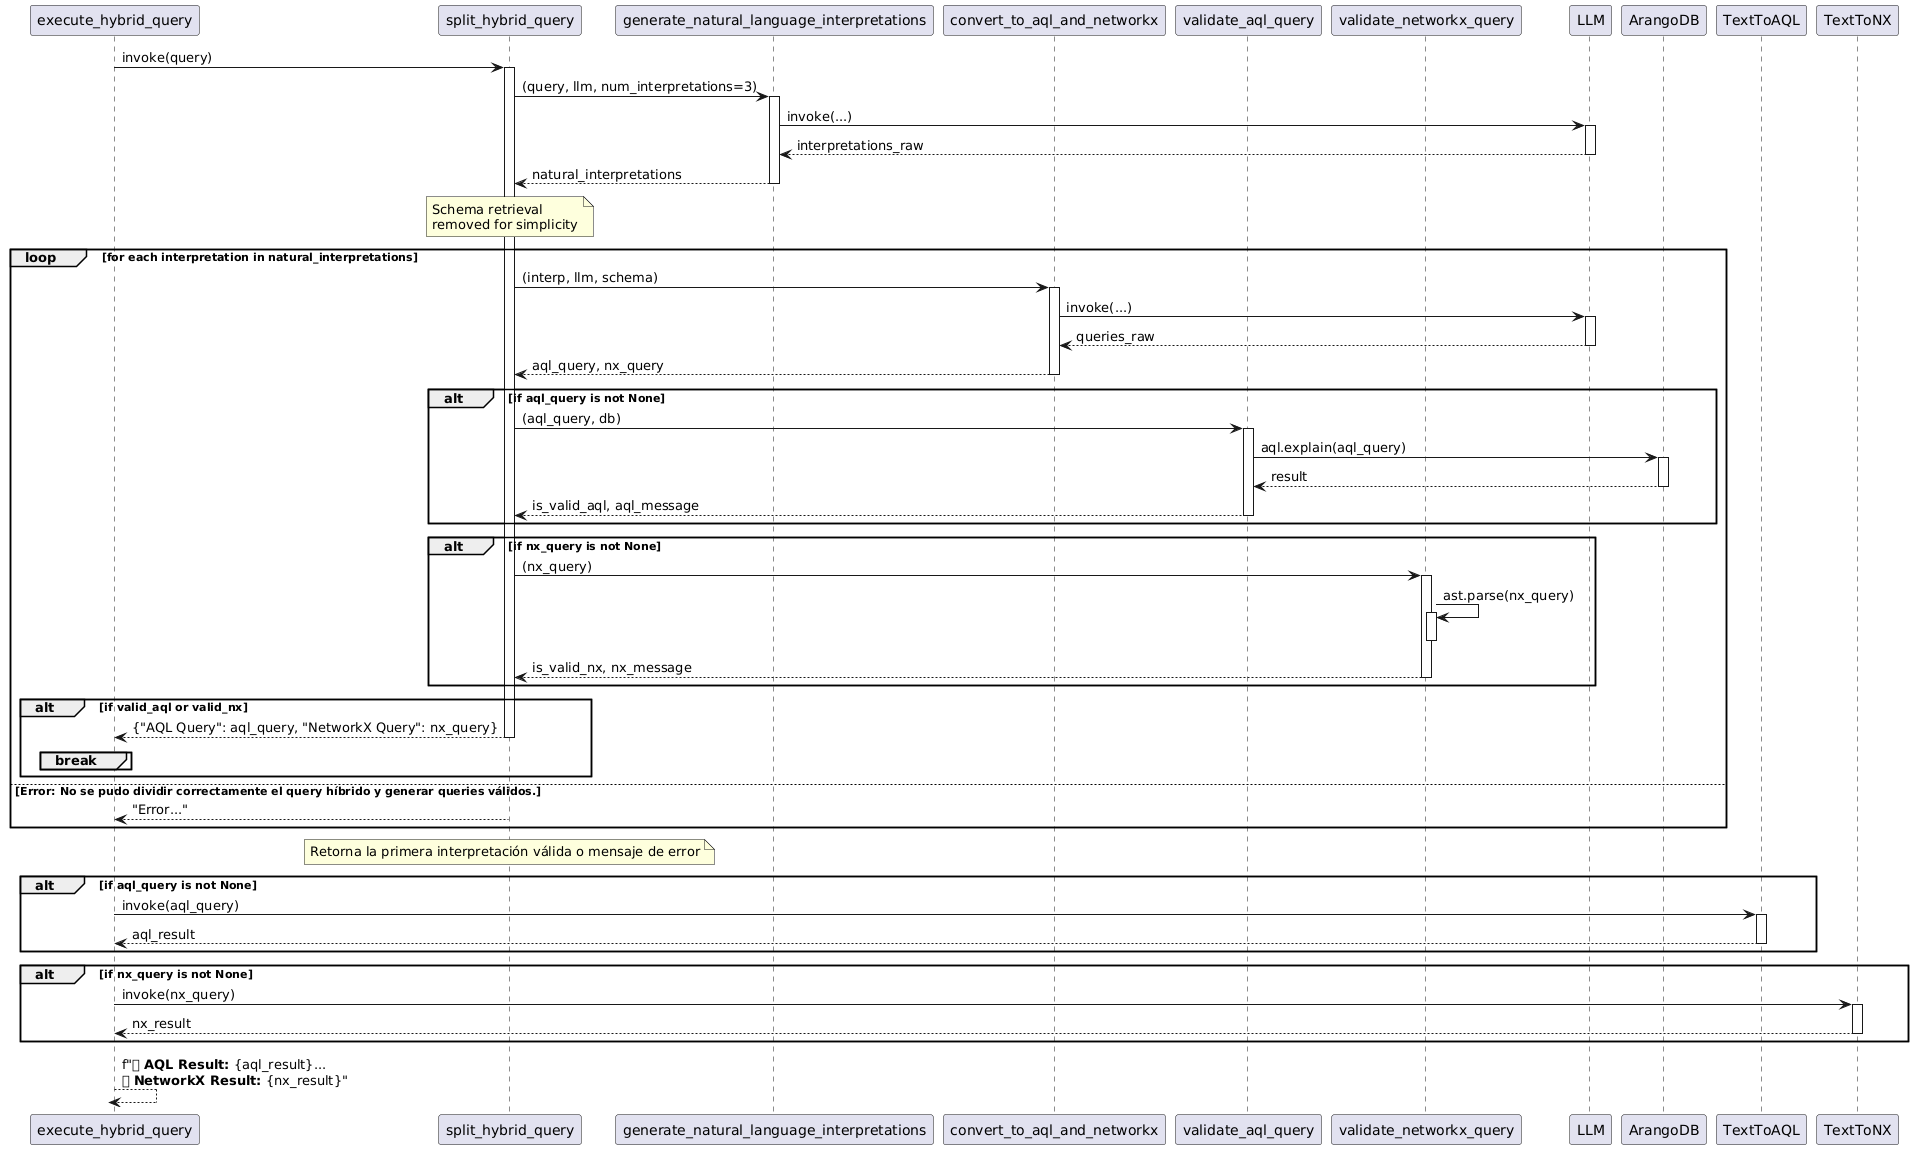

In [ ]:
import ast  # 📌 Importar `ast` para validar código Python (NetworkX)


def get_arangodb_schema(db):
    """
    Retrieves the metadata (schema) of all collections in the ArangoDB database.
    """
    schema_info = {}
    collections = db.collections()

    for col in collections:
        col_name = col["name"]
        try:
            # ✅ Corrected: Add `{}` as empty filter to avoid errors
            cursor = db.collection(col_name).find({}, limit=1)
            sample_doc = next(cursor)  # 🔹 Takes the first document of the collection
            schema_info[col_name] = list(sample_doc.keys())  # 🔍 Saves the fields of the collection
        except StopIteration:
            schema_info[col_name] = []  # 🔍 If the collection is empty, just save the name
        except Exception as e:
            print(f"⚠️ Error getting schema for {col_name}: {e}")
            schema_info[col_name] = []  # 🔹 Prevent an error from stopping execution

    return schema_info

def validate_if_coherent_query(query, schema):
    """
    Validates if a query is incoherent with the database schema using an LLM and suggests a coherent alternative.

    Args:
        query: Natural language query string.
        schema: Database schema (dictionary with node and relationship names and properties).

    Returns:
        dict: A dictionary with keys:
            - "isCoherent": True if the query is coherent, False if incoherent.
            - "Suggestion": A suggested coherent query string if incoherent and suggestion is possible,
                          None if coherent or if no suggestion is possible for incoherent query.
    """


    prompt_coherencia_en = """
    You are an expert in graph databases and query validation.
    Your task is to determine if a natural language query is **coherent** or **incoherent**
    with respect to a provided graph database schema.

    **Criteria to determine if a query is INCOHERENT:**

    A query is considered INCOHERENT if it meets **ANY** of the following criteria:

    1.  **Use of terms not present in the schema:** The query mentions node names (collections), property names, or relationship types
        that **DO NOT exist** in the provided database schema. This includes misspellings or slight variations
        of names that do not exactly match the schema.

    2.  **Logically invalid relationships according to the schema:** The query attempts to establish relationships or patterns between nodes or properties
        that are **not logically possible** or that contradict the schema structure. For example, trying to find the "average price of relationships"
        if relationships do not have a 'price' property, or trying to find "friends of products" if there is no logical relationship or connection
        defined in the schema between 'users' and 'products' through 'friends'.

    3.  **Query patterns that make no sense in the context of the schema:** The query, even if it uses terms from the schema, poses a question or pattern
        that **has no practical or analytical sense** given the nature of the data and the schema. For example, asking to "list all nodes and their colors"
        in a database schema representing financial transactions where nodes represent 'customers' and 'transactions' and do not have a 'color' property.
        Another example: asking for "the average degree of all restaurants" if 'degree' refers to user ratings and is not an intrinsic property of restaurants.

    4.  **Extreme ambiguity that prevents coherence:** The query is so vague or ambiguous that **it cannot be determined which part of the schema it refers to**
        or what information it is looking for in relation to the schema, making it incoherent in practice.  Slight ambiguity that can be resolved with context is not considered incoherence.

    **IMPORTANT:** A query is considered **COHERENT** if it **DOES NOT meet any** of the incoherence criteria defined above.
    That is, if the query uses terms from the schema validly, poses logically possible relationships, makes sense in the context of the schema, and is not extremely ambiguous.

    **Database Schema:**
    ```json
    {schema}
    ```

    **Natural Language Query:**
    "{query}"

    **CRITICAL Task:** Based on the incoherence criteria and the provided schema, analyze the query and decide if it is "INCOHERENT" or "COHERENT".

    **Respond with ONE WORD, in uppercase and without additional explanations:**

    "COHERENT" or "INCOHERENT"
    """
    prompt_llm = prompt_coherencia_en.format(query=query, schema=schema)
    #print("\n--- PROMPT SENT TO LLM (COHERENCE VALIDATION) ---")
    #print(prompt_llm)

    response = llm.invoke(prompt_llm)
    response_text = response.content.strip().upper() # Convert to uppercase for comparison

    print("\n--- LLM RESPONSE (COHERENCE VALIDATION) ---")
    print(response_text)

    if response_text == "INCOHERENT":
        return False
    elif response_text == "COHERENT":
        return True
    else:
        print(f"⚠️ Unexpected LLM response: '{response_text}'. Assuming query is COHERENT by default.")
        return True # In case of unexpected response, assume coherent to not block the process



def validate_aql_query(aql_query, db):
    """
    Validates if the AQL query is syntactically correct without executing it in ArangoDB.
    """
    try:
        # 🔍 Attempts to explain the query without executing it
        result = db.aql.explain(aql_query)
        return True, "✅ Valid AQL Query."
    except Exception as e:
        return False, f"❌ Error in AQL Query: {str(e)}"


def validate_networkx_query(nx_query):
    """
    Validates if the generated NetworkX code is syntactically correct without executing it.
    """
    try:
        ast.parse(nx_query)  # 📌 Uses `ast` to parse the code without executing it
        return True, "✅ Valid NetworkX Query."
    except SyntaxError as e:
        return False, f"❌ Error: Invalid code ({str(e)})"


def generate_natural_language_interpretations(query, llm, num_interpretations=3): # 📌 Added llm parameter
    """
    Generates multiple valid interpretations of a query **in natural language** using LLM.

    - Returns a list of different phrasings for the same query.
    - Ensures that interpretations are semantically different.
    """
    print("🔄 Generating natural language interpretations...")

    interpretations_raw = llm.invoke(f"""
    You are an expert in graph databases (ArangoDB) and network analysis (NetworkX).

    The user provided the following query:
    "{query}"

    Your task:
    - Generate **{num_interpretations} different valid interpretations** of how this query could be understood.
    - The interpretations must **rephrase the query differently** while keeping the meaning.
    - Ensure that the interpretations are **semantically different**.
    - The interpretations must be **in natural language**.
    - The interpretations must be **unique**.
    - The interpretations must be **different from the original query**.
    - If possible rephrase interpretations to be concise and short.
    - If possible rephrase interpretations so it can be translated into AQL and NetworkX.
    - Format **strict** answer format, **only** the interpretations, numbered and in a list:
    ```
    1. <Natural Language Interpretation 1>
    2. <Natural Language Interpretation 2>
    3. <Natural Language Interpretation 3>
    ```

    **Generate only the interpretations, nothing else.**
    """).content

    interpretation_list = []
    lines = interpretations_raw.strip().split('\n') # 📌 Process by lines for robustness
    for line in lines:
        if '.' in line and line.split('.', 1)[0].isdigit(): # 📌 Ensure format "number. interpretation"
            interpretation = line.split('.', 1)[1].strip()
            if interpretation: # 📌 Avoid empty lines
                interpretation_list.append(interpretation)


    print(f"📌 {len(interpretation_list)} natural language interpretations generated.")
    return interpretation_list

# 🔹 Get the schema and display it (moved to split_hybrid_query)
# schema = get_arangodb_schema(db) # ❌ Removed global schema

def convert_to_aql_and_networkx(interpretation, llm, schema, use_rag=False): # 📌 Added llm and schema parameters
    """
    Converts a **natural language** query interpretation into AQL and NetworkX queries using LLM.

    - Obtains dataset metadata directly from ArangoDB.
    - Ensures proper syntax before returning.
    """

    print(f"🔄 Converting interpretation to AQL + NetworkX:\n{interpretation}")

    # 🔍 Get the dataset schema automatically (schema is now passed as argument)
    dataset_metadata = schema

    if use_rag:
      print("use rag")
      relevant_documents = retrieve_networkx_docs(query)

    else:
      print("no use rag")
      relevant_documents = ""

    queries_raw = llm.invoke(f"""
    You are an expert in graph databases (ArangoDB) and network analysis (NetworkX).

    The user provided the following interpretation of a query:
    "{interpretation}"

    The dataset has the following schema:
    {dataset_metadata}

    Context of relevant documentation (NetworkX and ArangoDB AQL):
    {relevant_documents}

    Your CRITICAL task:
    - Convert the interpretation into **one valid AQL query** and **one valid NetworkX query**.
    - Ensure that the **AQL query is syntactically correct** and only references **existing collections** in the schema.
     - Ensure that ORDER BY and LIMIT appear before RETURN in AQL query
    - The **NetworkX query must be a valid Python snippet** that can be executed directly using the NetworkX library functions.
    - **Prioritize validity and syntactical correctness** of the generated queries over the complexity or "perfection" of the response. A simple and valid query is better than a complex and invalid one.
    - **In case of doubt or ambiguity, generate the simplest and safest query possible** that responds to the interpretation, even if it does not exploit all the capabilities of AQL or NetworkX.
    - If the interpretation cannot be translated to AQL or NetworkX, clearly indicate that **translation is not possible** for one or both languages, rather than generating an invalid query.
    - In case of the AQL query take into accont this rules:
      1.Ensure the correct order of clauses: WITH → FOR → COLLECT → ORDER BY → LIMIT → RETURN.
      2. The alias in COLLECT must match the field used in RETURN.
      3. ORDER BY and LIMIT must appear before RETURN, not after.
      4. This is an example of a **Incorrect query** in AQL because RETURN is before ORDER BY and LIMIT:
         WITH Sample_Collection
          FOR item IN Sample_Collection
          COLLECT category = item.category INTO grouped
          RETURN  category: category, count: LENGTH(grouped)
          ORDER BY count ASC
          LIMIT 1

    - Format **strict** answer format, **only** the queries, clearly indicating each language:
    ```
    AQL Query: `<query for AQL>`
    NetworkX Query: `<query for NetworkX>`
    ```

    **Generate only the queries, nothing else.**
    """).content

    aql_query = None # 📌 Initialize to None to handle error cases
    nx_query = None  # 📌 Initialize to None to handle error cases

    if "AQL Query:" in queries_raw and "NetworkX Query:" in queries_raw: # 📌 Check if both queries are present
        try: # 📌 Add try-except blocks to avoid LLM format errors
            aql_query = queries_raw.split("AQL Query:")[1].split("NetworkX Query:")[0].strip()
        except IndexError:
            print("⚠️ Error parsing AQL Query from LLM output.")
            aql_query = None

        try:
            nx_query = queries_raw.split("NetworkX Query:")[1].strip()
        except IndexError:
            print("⚠️ Error parsing NetworkX Query from LLM output.")
            nx_query = None
    else:
        print("⚠️ Incorrect LLM response format, 'AQL Query:' and 'NetworkX Query:' expected.")


    print("📌 **Generated Queries:**")
    print(f"🔹 **AQL Query:**\n{aql_query}")
    print(f"🔹 **NetworkX Query:**\n{nx_query}")

    return aql_query, nx_query


@tool
def split_hybrid_query(query: str, llm, db): # 📌 Added llm and db parameters
    """
    Uses an LLM to generate multiple valid interpretations of a hybrid query (AQL + NetworkX).

    - First generates multiple natural language interpretations.
    - Then converts each one into AQL & NetworkX.
    - Only executes the first valid interpretation.
    """

    # 🔹 1️⃣ Generate Natural Language Interpretations
    natural_interpretations = generate_natural_language_interpretations(query, llm, num_interpretations=3) # 📌 Pass llm

    print("\n📌 **Natural Language Interpretations:**")
    for idx, interp in enumerate(natural_interpretations):
        print(f"📝 **Interpretation {idx+1}:**\n{interp}\n{'-'*50}")

    # 🔄 2️⃣ Convert each interpretation to AQL + NetworkX and test them
    schema = get_arangodb_schema(db) # 📌 Get schema here, once per function call
    for idx, interp in enumerate(natural_interpretations):
        print(f"🔍 Testing Interpretation {idx+1}")

        # 🔹 Convert to AQL and NetworkX
        aql_query, nx_query = convert_to_aql_and_networkx(interp, llm, schema) # 📌 Pass llm and schema

        valid_aql = True # 📌 Use flags to track validity
        valid_nx = True  # 📌 Use flags to track validity

        # 🔍 Validate AQL Query in ArangoDB
        if aql_query:
            is_valid_aql, aql_message = validate_aql_query(aql_query, db) # 📌 Pass db to validate_aql_query
            print(aql_message)
            if not is_valid_aql:
                print("⚠️ Invalid AQL Query.")
                valid_aql = False # 📌 Update flag
        else:
            print("⚠️ No AQL Query generated for this interpretation.")
            valid_aql = False # 📌 Update flag


        # 🔍 Validate NetworkX Query syntactically
        if nx_query:
            is_valid_nx, nx_message = validate_networkx_query(nx_query)
            print(nx_message)
            if not is_valid_nx:
                print("⚠️ Invalid NetworkX Query.")
                valid_nx = False # 📌 Update flag
        else:
            print("⚠️ No NetworkX Query generated for this interpretation.")
            valid_nx = False # 📌 Update flag


        # ✅ If at least one is valid, or both (depending on desired logic)
        if valid_aql or valid_nx: # 📌 Modify return condition as needed
        #if valid_aql and valid_nx: # ✅ If both parts are valid, use this interpretation (original logic)
            return {"AQL Query": aql_query, "NetworkX Query": nx_query}

    return "❌ Error: Could not correctly split the hybrid query and generate valid queries."

def execute_hybrid_query(query): # 📌 Added dependencies as parameters
    """
    Splits the hybrid query into AQL and NetworkX parts, executes both, and merges results.
    """

    # 🔹 1. Split the query into two parts
    split_result = split_hybrid_query.invoke({"query": query, "llm": llm, "db": db})  # 📌 Pass llm and db as arguments

    # 🔹 2. Extract AQL and NetworkX from the result
    aql_query = split_result.get("AQL Query") # 📌 Use .get() to avoid KeyError
    nx_query = split_result.get("NetworkX Query") # 📌 Use .get() to avoid KeyError


    # ❌ Verify that at least one part exists and is valid (or desired logic)
    if not aql_query and not nx_query: # 📌 Modify condition as needed
    #if not aql_query or not nx_query: # ❌ Verify that both parts exist (original logic)
        return "❌ Error: Could not correctly split the hybrid query or generate valid queries."

    aql_result = None # 📌 Initialize to None to handle error cases
    nx_result = None  # 📌 Initialize to None to handle error cases

    # 🔹 3. Execute both parts with error handling
    if aql_query: # 📌 Execute AQL only if there is a query
        try:
            aql_result = text_to_aql_to_text.invoke(aql_query)
        except Exception as e:
            aql_result = f"❌ Error in AQL: {str(e)}" # 📌 Report error instead of None


    if nx_query: # 📌 Execute NetworkX only if there is a query
        try:
            nx_result = text_to_nx_algorithm_to_text_v2.invoke(nx_query)
        except Exception as e:
            nx_result = f"❌ Error in NetworkX: {str(e)}" # 📌 Report error instead of None

    # 🔹 4. Merge the results into a single message
    return f"🔹 **AQL Result:** {aql_result}\n🔹 **NetworkX Result:** {nx_result}"



#### ✅ Agentic Query Function

In [ ]:
# Note: Consider implementing a hybrid tool that combines both AQL & NetworkX Algorithms!
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text_v2, split_hybrid_query]

def query_graph(query, use_rag = False):
    """
    Procesa la consulta utilizando AQL, NetworkX o un enfoque híbrido.
    - Primero clasifica la consulta como AQL, NetworkX o híbrida.
    - Si es híbrida, ejecuta ambas estrategias y fusiona resultados.
    - Maneja errores de clasificación o ejecución de herramientas.
    - Si AQL o NetworkX falla, intenta el modo híbrido como fallback.
    """

    # 1. Validación de entrada
    if not query or not isinstance(query, str) or len(query.strip()) == 0:
        return "Error: La consulta está vacía. Proporcione una consulta válida."

    try:
        # 2. Clasificar la consulta
        classification = classify_query(query, use_rag)
        print(f"Using classification {classification}")
        if "NetworkX" in classification:
            try:
                return text_to_nx_algorithm_to_text_v2.invoke(query)
            except Exception as e:
                print(f"❌ Error en NETX, intentando Hybrid. Detalle: {e}")
                classification = "Hybrid"  # Fallback a Hybrid
        elif "AQL" in classification:
            try:
                return text_to_aql_to_text.invoke(query)
            except Exception as e:
                print(f"❌ Error en AQL, intentando Hybrid. Detalle: {e}")
                classification = "Hybrid"  # Fallback a Hybrid
        elif "Hybrid" in classification:
            return execute_hybrid_query(query)
        else:
            return "No se pudo clasificar la consulta. Intente reformularla."

    except Exception as e:
        return f"❌ Error inesperado: {str(e)}. Intente nuevamente."

    # 🚀 5. React Agent (para consultas conversacionales)
    try:
        tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text_v2, split_hybrid_query]
        app = create_react_agent(llm, tools)
        final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
        return final_state["messages"][-1].content

    except Exception as e:
        return f"⚠️ Error al ejecutar React Agent: {str(e)}"


### ✅ Clasification Agent

##### This Agent can select wich Method is better for the query (AQL, NetWorkX, Hibryd)

In [ ]:
# Optimized classification prompt with preference for AQL first
classification_prompt = """
You are an expert in graph databases and algorithms. Your **CRITICAL TASK** is to classify a given natural language query think step-by-step and decide whether an **AQL** (Arango Query Language) or **NetworkX** query or a **Hybrid* Hybrid approach should be used. is more suitable, based on the following detailed criteria. **Always prefer AQL if the query can be solved using it. Only use NetworkX if it is not possible or optimal with AQL.**
**IMPORTANT:  Use NetworkX or Hybrid ONLY when AQL is insufficient or clearly less optimal for the core task.

Follow a step-by-step thought process:

1. **Analyze the query:** Identify the core intent, operations, and data needs expressed in the natural language query.
2. **Evaluate AQL suitability:**  Determine if AQL can effectively and efficiently address the *primary objective* of the query based on the criteria below.  Remember, prefer AQL when it's a viable option.
3. **Assess NetworkX necessity:** Only if AQL is not suitable or significantly less efficient for the *core task*, consider if NetworkX capabilities are required.
4. **Hybrid approach consideration:** If the query inherently involves both data retrieval/manipulation (best with AQL) AND graph analysis/algorithms (NetworkX), then consider "Hybrid".
5. **Justify your classification:** Briefly think about why AQL, NetworkX, or Hybrid is the best choice based on the criteria and examples provided.
6. **Strict Output:** Respond **ONLY** with **"AQL"**, **"NetworkX"**, or **"Hybrid"**. No other text or explanation is needed in your final answer.


- **Use AQL if the query meets any of these conditions:**
  1. **Data retrieval & filtering:** Searching, filtering, or retrieving specific nodes/edges.
  2. **Graph traversal:** Simple traversals like "find all direct neighbors" or "find shortest path."
  3. **Aggregation & counting:** Counting nodes/edges, calculating averages, or simple analytics.
  4. **Sorting & ordering:** Ordering results based on properties.
  5. **CRUD operations:** Creating, updating, or deleting nodes and relationships.
  6. **Pattern matching:** Finding specific structures (e.g., "Find all users who purchased product X").
  7. **Pathfinding with constraints:** Finding shortest paths with specific conditions.
  8. **Subgraph extraction:** Extracting a subset of the graph based on conditions.
  9. **Text search in graph properties:** Searching for specific text patterns in node/edge attributes.
  10. **Direct relationship queries:** Finding direct links between entities.


- **Use NetworkX only if:**
  1. **Graph centrality analysis:** Identifying the most important nodes based on influence (e.g., "Who are the most connected people in the network?").
  2. **Community detection:** Discovering hidden groups or clusters in the graph (e.g., "Are there groups of people who interact more among themselves than with others?").
  3. **Graph structure analysis:** Understanding the overall shape of the graph, including its density and connectivity (e.g., "Is this network highly connected or fragmented?").
  4. **Network simulations:** Simulating the spread of information or events in the network (e.g., "How fast would a rumor spread in this network?").
  5. **Graph-based recommendations:** Making suggestions based on graph structures (e.g., "Recommend new connections for user A based on their current friends.").
  6. **Graph decomposition:** Breaking down the network into meaningful components (e.g., "Identify isolated groups in the social network.").
  7. **Anomaly detection:** Finding unusual patterns that stand out (e.g., "Detect fraudulent transactions based on network behavior.").
  8. **Path efficiency evaluation:** Determining if the shortest path is the most optimal in a complex network (e.g., "Are the fastest routes also the most frequently used ones?").
  9. **Network robustness analysis:** Measuring how the removal of certain nodes affects the graph (e.g., "What happens if we remove the top 5 influencers from the network?").
  10. **Advanced graph metrics:** Computing network properties like clustering coefficient, assortativity, or eigenvalues (e.g., "How strongly connected are different parts of the network?").

- **Use "Hybrid" if:**
  - The query involves **both data retrieval** (AQL) and **graph analytics** (NetworkX).
  - The query requires **filtering data first** (AQL) and then **applying a NetworkX algorithm**.
  - The query needs **combining results from AQL and NetworkX for a final answer**.
  - **Choose "Hybrid" when the query inherently combines:**
     - **AQL for initial data filtering, retrieval, or manipulation**, AND
     - **NetworkX for subsequent complex graph analysis or algorithmic processing** on the filtered data.
     -  Essentially, if you need to **first get a subset of the graph data using AQL, and then perform NetworkX operations on that subset to answer the query**, it's Hybrid.

### **Examples for AQL Queries:**
1. "Who are the direct friends of Alice?"
2. "List the top 5 products purchased in the last week."
3. "How many transactions took place in the past 24 hours?"
4. "Which employees report directly to the CEO?"
5. "Find the shortest path between city A and city B."

### **Examples for NetworkX Queries:**
1. "Who are the most influential users in the network?"  (PageRank, Betweenness Centrality)
2. "Are there any tightly-knit communities in the social network?" (Degree Centrality, Closeness Centrality)
3. "How well connected is this graph overall?"
4. "If we remove the top 10 most connected users, how does the network change?"
5. "Which people in the network act as bridges between different communities?"
6. "Which researchers are the most cited in this academic collaboration graph?" (Eigenvector Centrality, HITS algorithm)
7. "Find the nodes that bridge different parts of the network." (Betweenness Centrality)

### **Examples - Hybrid Approach Queries (Combine AQL and NetworkX):**
1. "Influential users among those buying > 10 products - find them."
    - **AQL part:** Get users with > 10 purchases.
    - **NetworkX part:** PageRank on those users.

2. "Communities among users with > 20 interactions - detect them."
    - **AQL part:** Users with > 20 interactions.
    - **NetworkX part:** Community detection.

3. "Shortest path between friends for > 5 years - find the path."
    - **AQL part:** Friendships > 5 years old.
    - **NetworkX part:** Shortest path.


**Query:** {query}

Context of relevant documentation (NetworkX and ArangoDB AQL):
{context_text}



**Respond only with "AQL" or "NetworkX" or "Hybrid"**
"""

def classify_query(query, use_rag = False):

    # 1. Recuperar documentos relevantes de la documentación de NetworkX
    #relevant_docs = retrieve_networkx_docs(query)  # Agregue esto

    """
    Uses an LLM with structured criteria and examples to determine if AQL or NetworkX should be used.
    Prefers AQL whenever possible, using NetworkX only when necessary.
    """

    # 2. Verify if query is Coherent or can indeed be responder with the current schema and data
    #schema = get_arangodb_schema(db) # 📌 Get schema here, once per function call
    #isCoherent = validate_if_coherent_query(query, schema)
    #print("Is the query Coherent?  ", isCoherent)
    #if not isCoherent:
        #return "❌ Error: La consulta no es coherente con el esquema actual. Te sugerimos este query "


    if use_rag:
        print("classify_query_rag")
         # 🔍 1. Búsqueda en la base de datos vectorial basada en la consulta
        relevant_documents = retrieve_networkx_docs(query)
        response = llm.invoke(classification_prompt.format(query=query, context_text = relevant_documents ))  # Devuelve un AIMessage
        response_text = response.content.strip()  # Extrae el contenido de la respuesta y limpia espacios
    else:
        print("classify_query")
        response = llm.invoke(classification_prompt.format(query=query, context_text = "" ))  # Devuelve un AIMessage
        response_text = response.content.strip()  # Extrae el contenido de la respuesta y limpia espacios
        print("classify_query response = ", response_text)

    if response_text in ["AQL", "NetworkX", "Hybrid"]:
        return response_text
    return "AQL"  # Default fallback to AQL




#### ⚪ Agentes en un Workflow de LangChain

In [ ]:
# 🔥 1. Definimos la estructura del estado compartido
class GraphState(TypedDict):
    query: str
    classification: str
    result_aql: str
    result_nx: str
    final_result: str
    use_rag: bool

# 🔍 2. Agentes especializados con manejo de errores
def classify_agent(state: GraphState) -> GraphState:
    """Clasifica la consulta en AQL, NetworkX o híbrida."""
    query = state["query"]
    if not query or not isinstance(query, str) or len(query.strip()) == 0:
        return {**state, "final_result": "Error: La consulta está vacía. Proporcione una consulta válida."}

    try:
        classification = classify_query(query, False)
        return {**state, "classification": classification}
    except Exception as e:
        return {**state, "final_result": f"❌ Error en clasificación: {str(e)}"}

def aql_agent(state: GraphState) -> GraphState:
    """Ejecuta una consulta en AQL si corresponde."""
    if state["classification"] in ["AQL", "Hybrid"]:
        try:
            result_aql = text_to_aql_to_text.invoke(state["query"])
            return {**state, "result_aql": result_aql}
        except Exception as e:
            return {**state, "result_aql": f"⚠️ Error en AQL: {str(e)}"}
    return state

def networkx_agent(state: GraphState) -> GraphState:
    """Ejecuta un análisis de NetworkX si corresponde."""
    if state["classification"] in ["NetworkX", "Hybrid"]:
        try:
            result_nx = text_to_nx_algorithm_to_text_v2.invoke(state["query"])
            return {**state, "result_nx": result_nx}
        except Exception as e:
            return {**state, "result_nx": f"⚠️ Error en NetworkX: {str(e)}"}
    return state

def hybrid_agent(state: GraphState) -> GraphState:
    """Fusiona los resultados de AQL y NetworkX si es híbrido."""
    if state["classification"] == "Hybrid":
        final_result = execute_hybrid_query(query) #f"🔹 **AQL Result:** {state['result_aql']}\n🔹 **NetworkX Result:** {state['result_nx']}"
        return {**state, "final_result": final_result}
    return state

def final_result_agent(state: GraphState) -> str:
    """Devuelve el resultado final basado en la clasificación."""
    if state["final_result"]:
        return state["final_result"]
    if state["classification"] == "AQL":
        return state["result_aql"]
    elif state["classification"] == "NetworkX":
        return state["result_nx"]
    elif state["classification"] == "Hybrid":
        return state["final_result"]
    return "⚠️ No se pudo clasificar la consulta."

# 🚀 3. Construimos el sistema multiagente con LangGraph
workflow = StateGraph(GraphState)
workflow.add_node("classifier", classify_agent)
workflow.add_node("aql", aql_agent)
workflow.add_node("networkx", networkx_agent)
workflow.add_node("hybrid", hybrid_agent)
workflow.add_node("result_processor", final_result_agent)  # 🔹 Cambié "final_result" a "result_processor"

# 🔄 4. Definimos la lógica del flujo de trabajo
workflow.add_edge("classifier", "aql")
workflow.add_edge("classifier", "networkx")
workflow.add_edge("aql", "hybrid")
workflow.add_edge("networkx", "hybrid")
workflow.add_edge("hybrid", "result_processor")  # 🔹 Ajusté el nombre aquí
workflow.add_edge("aql", "result_processor")  # 🔹 Ajusté el nombre aquí
workflow.add_edge("networkx", "result_processor")  # 🔹 Ajusté el nombre aquí

workflow.set_entry_point("classifier")
workflow.set_finish_point("result_processor")  # 🔹 Ajusté el nombre aquí
compiled_workflow = workflow.compile()

# 🎯 5. Función final para ejecutar consultas con manejo de errores
def query_graph_multiagent(query: str) -> str:
    """Ejecuta la consulta en el sistema multiagente con manejo de errores."""
    initial_state = {
        "query": query,
        "classification": "",
        "result_aql": "",
        "result_nx": "",
        "final_result": "",
        "use_rag": False
    }
    try:
        # 🔹 **Ejecutar el workflow compilado con run() en vez de invoke()**
        final_state = compiled_workflow.invoke(initial_state) # 🔥 Asegurar que corra correctamente
        return final_state["final_result"]
    except Exception as e:
        return f"⚠️ Error inesperado: {str(e)}. Intente nuevamente."

#### ✔️ TEST Query

In [ ]:
# Query Multiagent
import time

#query = "Find the 3 closest restaurants." #AQL
#query = "Find the restaurant with the most connections in the database. " #(NetworkX)
query = "What is the amenity type with the fewest instances in the area? " #(NetworkX)
#query = "Count how many places there are for each type of amenity."
#query = "How many restaurants are in the database? (AQL)"
#query = "How many nightclubs are in the database? (AQL)"
#query = "How many records are in the database? (AQL)"
#query = "How many theaters exist in the database? (AQL)"
#query = "Which restaurants are directly connected to each other? (NetworkX)"
#query = "What is the clustering coefficient of the graph? (NetworkX)"
#query = "Which restaurant has the most connections? (NetworkX)"
#query = "Who is the most connected restaurant within a 500m radius? " #(Hybrid)
#query = "Count how many places there are for each type of amenity. (AQL)"
#query = "List all hotels with a rating above 4.5. (AQL)"
#query = "Find the shortest path between two specific restaurants. (NetworkX)"
#query = "What is the average rating of all parks? (AQL)"
#query = "Show me all places within a 1km radius of a given location. (AQL)"
#query = "Which amenities are in the same connected component as the museum? (NetworkX)"
#query = "Give me the top 5 highest-rated attractions. (AQL)"
#query = "Find the degree centrality of each node in the graph. (NetworkX)"
#query = "Are there any restaurants connected to both a park and a theater? (Hybrid)"
#query = "What is the density of the graph? (NetworkX)"
#query = "Which amenities are most frequently connected to restaurants? (Hybrid)"
query = "Find the nearest restaurant within a 100-meter radius of the cafe with the most connections" # (Hybrid)


#query = "Encuentra el restaurante con más conexiones en la base de datos" #(NETX-OK)
#query =  "Encuentra los 3 restaurantes mas cercanos." #(AQL-OK)
#query = "Cual es el tipo de amenitie con menos cantidad en la zona?" #(NETX-OK) Antes funcionaba
#query = "¿Cuántos restaurantes hay en la base de datos?" # (AQL- -OK)
#query = "¿Cuántos clubes de noche hay en la base de datos?" # (AQL- -OK)
#query = "¿Cuántos registros hay en la base de datos?" # (AQL- -OK)
#query = "¿Cuántos teatros existen en la base de datos?" # (AQL- -OK)
#query = "¿Cuáles son los restaurantes que están conectados directamente entre sí?" # AQL-OK
#query = "¿Cuál es el coeficiente de agrupamiento (clustering coefficient) del grafo?" # NETX-OK
#query = "¿Cuál es el restaurante con más conexiones?" # NETX-OK
#query = "¿Quién es el restaurante más conectado dentro de un radio de 500m?" # AQL o Netx -Not OK
#query = "Count how many places there are for each type of amenity."

start_time = time.time()
result = query_graph(query, False)
end_time = time.time()
duration = end_time - start_time

print("🔍 Query:", query)
print("🚀 Result:", result)
print(f"⏱️ Tiempo de ejecución: {duration:.4f} segundos") # 📌 Imprimir la duración formateada


classify_query
classify_query response =  Hybrid
Using classification Hybrid
🔄 Generating natural language interpretations...
📌 3 natural language interpretations generated.

📌 **Natural Language Interpretations:**
📝 **Interpretation 1:**
Identify the closest restaurant within 100 meters of the cafe that has the highest number of connections.
--------------------------------------------------
📝 **Interpretation 2:**
Locate the nearest eatery situated within a 100-meter distance from the most connected cafe.
--------------------------------------------------
📝 **Interpretation 3:**
Find the restaurant that is within a 100-meter radius of the cafe with the greatest number of links.
--------------------------------------------------
🔍 Testing Interpretation 1
🔄 Converting interpretation to AQL + NetworkX:
Identify the closest restaurant within 100 meters of the cafe that has the highest number of connections.
no use rag
📌 **Generated Queries:**
🔹 **AQL Query:**
WITH Places_node
FOR cafe I

# TEST AREA (Only for Developmeny Purposes

In [ ]:
aql_query = "RETURN COUNT(FOR place IN Places_node FILTER place.amenity == 'restaurant' RETURN place)"
result = db.aql.execute(aql_query)

# Obtener y mostrar el resultado
count = result.next()
print(f"Número de restaurantes: {count}")

Número de restaurantes: 70


In [ ]:
# Ejecutar la consulta AQL para obtener los amenities únicos
aql_query = """
FOR place IN Places_node
COLLECT amenity = place.amenity
RETURN amenity
"""
result = db.aql.execute(aql_query)

# Mostrar los resultados
amenities = list(result)
print("Lista de amenities únicos:")
for amenity in amenities:
    print(amenity)

Lista de amenities únicos:
bar
bureau_de_change
cafe
clock
dentist
fast_food
ice_cream
music_venue
nightclub
pharmacy
pub
restaurant
theatre


In [ ]:
query = "¿Cuántos restaurantes hay en la base de datos?" #(Hybrid)
query_graph_multiagent(query)

classify_query


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Places_node
RETURN COUNT(Places_node) FILTER Places_node.amenity == 'restaurant'

AQL Query Execution Error: 
syntax error, unexpected FILTER declaration, expecting end of query string near 'FILTER Places_node.amenity == 'r...' at position 3:27

AQL Query (2):
WITH Places_node
RETURN COUNT(FILTER Places_node.amenity == 'restaurant')

AQL Query Execution Error: 
syntax error, unexpected ) near ')
' at position 3:56

AQL Query (3):
WITH Places_node
RETURN COUNT(FILTER Places_node.amenity == 'restaurant')

AQL Query Execution Error: 
syntax error, unexpected ) near ')
' at position 3:56



"⚠️ Error inesperado: At key 'query': Can receive only one value per step. Use an Annotated key to handle multiple values.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE. Intente nuevamente."

# Experimentation (Optional)

In [ ]:
# Lista de queries con su clasificación correcta (ground truth)
queries = [
    ("Who are the direct friends of user 10?", "AQL"),
    #("Find the shortest path between user 15 and user 45.", "AQL"),
    #("How many connections does user 20 have?", "AQL"),
    #("Retrieve all mutual friends between user 30 and user 50.", "AQL"),
    #("List all users who have more than 100 friends.", "AQL"),
    #("Identify the most influential users in the network.", "NetworkX"),
    #("Detect communities in the Facebook network.", "NetworkX"),
    #("Calculate the average clustering coefficient of the graph.", "NetworkX"),
    #("If we remove the top 5 most connected users, how does the network change?", "NetworkX"),
    ("Find the most central user based on betweenness centrality.", "NetworkX"),
    # "Find all users who are two hops away from user 42 and rank them by influence.",  # ⚠️ AQL para los vecinos, pero NetworkX para la influencia
    #"Identify communities in the network, but only include users with at least 10 friends.",  # ⚠️ NetworkX para detección de comunidades, pero AQL para el filtro
    #"Find the most central user in the network among those who have posted at least 5 times.",  # ⚠️ AQL para filtrar, NetworkX para centralidad
    #"List the shortest paths between user 5 and user 50, considering only paths that go through user 20.",  # ⚠️ AQL para caminos, pero con condiciones avanzadas
    #"Determine if removing user 100 would split the network into disconnected components.",  # ⚠️ NetworkX, pero AQL podría evaluar relaciones antes
    #"Find the most common friend among all pairs of users in the network.",  # ⚠️ AQL para contar amigos en común, pero NetworkX si usamos métricas
    #"Simulate the spread of a message starting from user 10.",  # ⚠️ NetworkX para simulación, pero podría requerir extracción de subgrafos con AQL
    #"Predict which users are most likely to form new friendships based on shared connections.",  # ⚠️ NetworkX para predicción, pero AQL para datos base
    #"Rank users by their influence, but only among those connected to at least 5 different communities.",  # ⚠️ NetworkX para influencia, AQL para comunidades
    #"Find the most active groups of friends who interact frequently.",  # ⚠️ Ambiguo: AQL puede buscar interacciones, pero NetworkX detecta comunidades
]

correct_count = 0  # Contador de aciertos
total_queries = len(queries)  # Total de queries

for query, expected in queries:
    result = classify_query(query)  # Clasifica la query con el LLM
    is_correct = result == expected  # Verifica si la predicción es correcta
    correct_count += is_correct  # Suma 1 si es correcto

    # Imprime cada resultado con un ✅ o ❌ para visualizar errores
    print(f"Query: {query} → Decision: {result} (Expected: {expected}) {'✅' if is_correct else '❌'}")

# Muestra el total de aciertos
print(f"\nTotal correct classifications: {correct_count}/{total_queries} ({(correct_count/total_queries) * 100:.2f}%)")


classify_query
Query: Who are the direct friends of user 10? → Decision: AQL (Expected: AQL) ✅
classify_query
Query: Find the most central user based on betweenness centrality. → Decision: NetworkX (Expected: NetworkX) ✅

Total correct classifications: 2/2 (100.00%)


# ✨ UI Interface using Gradio

In [ ]:
# 8. (Optional) Set up UI via Gradio

#!pip install gradio -q
!pip install --upgrade gradio

In [ ]:
import gradio as gr

# --- Make sure ALL your previous functions are defined here ---
# (GraphState, classify_agent, aql_agent, networkx_agent, hybrid_agent,
# final_result_agent, workflow, compiled_workflow, query_graph_multiagent,
# classify_query, text_to_aql_to_text, text_to_nx_algorithm_to_text_v2, etc.)
# ... Paste all your previous code here, including the workflow compilation ...
# ... Ensure that 'compiled_workflow' is defined and accessible ...


def gradio_interface_function(query):
    """
    Wrapper function to use query_graph_multiagent with Gradio Interface.
    """
    try:
        result = query_graph(query, False)
        return result
    except Exception as e:
        return f"⚠️ An error occurred while executing the query:\n{e}"


iface = gr.Interface(
    fn=gradio_interface_function,
    inputs=gr.Textbox(lines=5, placeholder="Enter your query here..."), # Textbox widget for input
    outputs=gr.Textbox(lines=10, placeholder="The result will appear here..."), # Textbox widget for output
    title="GeoMagic - ArangoGraph Query for Amenities in a Map ",
    description="Write a natural language query and the system will determine whether to use AQL or NetworkX (or hybrid) to answer it. The data loaded is from Madrid, España for a 0.5Km Radius",
    examples=[
         "Find the restaurant with the most connections in the database. (NetworkX)",
        "Find the 3 closest restaurants. (AQL)",
        "What is the amenity type with the fewest instances in the area? (NetworkX)",
        "How many restaurants are in the database? (AQL)",
        "How many nightclubs are in the database? (AQL)",
        "How many records are in the database? (AQL)",
        "How many theaters exist in the database? (AQL)",
        "Which restaurants are directly connected to each other? (NetworkX)",
        "What is the clustering coefficient of the graph? (NetworkX)",
        "Which restaurant has the most connections? (NetworkX)",
        "Who is the most connected restaurant within a 500m radius? (Hybrid)",
        "Count how many places there are for each type of amenity. (AQL)",
        "List all hotels with a rating above 4.5. (AQL)",
        "Find the shortest path between two specific restaurants. (NetworkX)",
        "What is the average rating of all parks? (AQL)",
        "Show me all places within a 1km radius of a given location. (AQL)",
        "Which amenities are in the same connected component as the museum? (NetworkX)",
        "Give me the top 5 highest-rated attractions. (AQL)",
        "Find the degree centrality of each node in the graph. (NetworkX)",
        "Are there any restaurants connected to both a park and a theater? (Hybrid)",
        "What is the density of the graph? (NetworkX)",
        "Which amenities are most frequently connected to restaurants? (Hybrid)"
    ]
)


iface.launch(share=True) # share=False for local use in Jupyter Notebook

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/anyio/_core/_eventloop.py", line 151, in get_asynclib
    del threadlocals.current_token
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'anyio._backends._asyncio'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/d

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a8115fd2199dff94f5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/anyio/_core/_eventloop.py", line 151, in get_asynclib
    del threadlocals.current_token
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'anyio._backends._asyncio'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/d

KeyboardInterrupt: 